In [35]:
#|default_exp emotion_recognition

In [33]:
#|export
# import
# from bing_image_downloader import downloader
import nbdev

from duckduckgo_search import ddg_images
from fastbook import search_images_ddg
from fastcore.all import *
from fastai.vision.all import *

NameError: name 'nbdev_new' is not defined

In [20]:
#|export
#init hydra
from hydra import initialize, compose
from hydra.utils import to_absolute_path as abspath

with initialize(version_base=None, config_path="../configs"):
    config = compose(config_name="main-config.yaml")

data_path = abspath("../" + config.data.path)
model_path = abspath("../" + config.model.path)

In [112]:
#|export
#search item function
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return search_images_ddg(term, max_images=max_images)

In [14]:
#urls
urls = search_images('cat', max_images=1)
if len(urls) == 0:
    print('No images found')
else:
    print(urls[0])

Searching for 'cat'
http://2.bp.blogspot.com/-mM8oS_-yJpQ/T2wRBliLA2I/AAAAAAAAGKc/qfl1l7mD2Q0/s1600/Cat-07.jpg


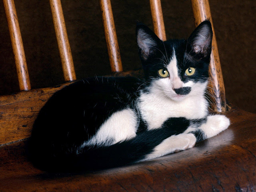

In [15]:
from fastdownload import download_url

dest = data_path + 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'happy face human'


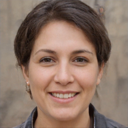

In [103]:
#in two lines
download_url(search_images('happy face human', max_images=1)[0], data_path +'/test/happy.jpg', show_progress=False)
Image.open(data_path +'/test/happy.jpg').to_thumb(128,128)

Searching for 'sad face'


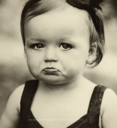

In [104]:
download_url(search_images('sad face', max_images=1)[0], data_path +'/test/sad.jpg', show_progress=False)
Image.open(data_path +'/test/sad.jpg').to_thumb(128,128)

Searching for 'angry face human'


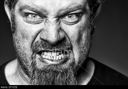

In [105]:
download_url(search_images('angry face human', max_images=1)[0], data_path +'/test/angry.jpg', show_progress=False)
Image.open(data_path +'/test/angry.jpg').to_thumb(128,128)

Searching for 'surprised face human'


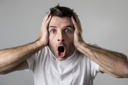

In [109]:
download_url(search_images('surprised face human', max_images=1)[0], data_path +'/test/surprised.jpg', show_progress=False)
Image.open(data_path +'/test/surprised.jpg').to_thumb(128,128)

Searching for 'smiling human face'


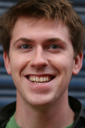

In [107]:
download_url(search_images('smiling human face', max_images=1)[0], data_path +'/test/happy.jpg', show_progress=False)
Image.open(data_path +'/test/happy.jpg').to_thumb(128,128)

In [60]:
searches = 'happy', 'sad', 'angry', 'suprised'
from time import sleep

for search in searches:
    dest = f'{data_path}/{search}'

    download_images(dest, urls = search_images(f'{search} face photo'))
    sleep(10)
    download_images(dest, urls = search_images(f'{search} human photo'))
    sleep(10)
    download_images(dest, urls = search_images(f'{search} human face'))
    sleep(10)
    download_images(dest, urls = search_images(f'{search} human face photo'))


Searching for 'happy face photo'
Searching for 'happy human photo'
Searching for 'happy human face'
Searching for 'happy human face photo'
Searching for 'sad face photo'
Searching for 'sad human photo'
Searching for 'sad human face'
Searching for 'sad human face photo'
Searching for 'angry face photo'
Searching for 'angry human photo'
Searching for 'angry human face'
Searching for 'angry human face photo'
Searching for 'flirting face photo'
Searching for 'flirting human photo'
Searching for 'flirting human face'
Searching for 'flirting human face photo'
Searching for 'supprised face photo'
Searching for 'supprised human photo'
Searching for 'supprised human face'
Searching for 'supprised human face photo'


In [61]:
failed = verify_images(get_image_files(data_path))
failed.map(Path.unlink)
len(failed)

7

In [62]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(data_path, bs=32)

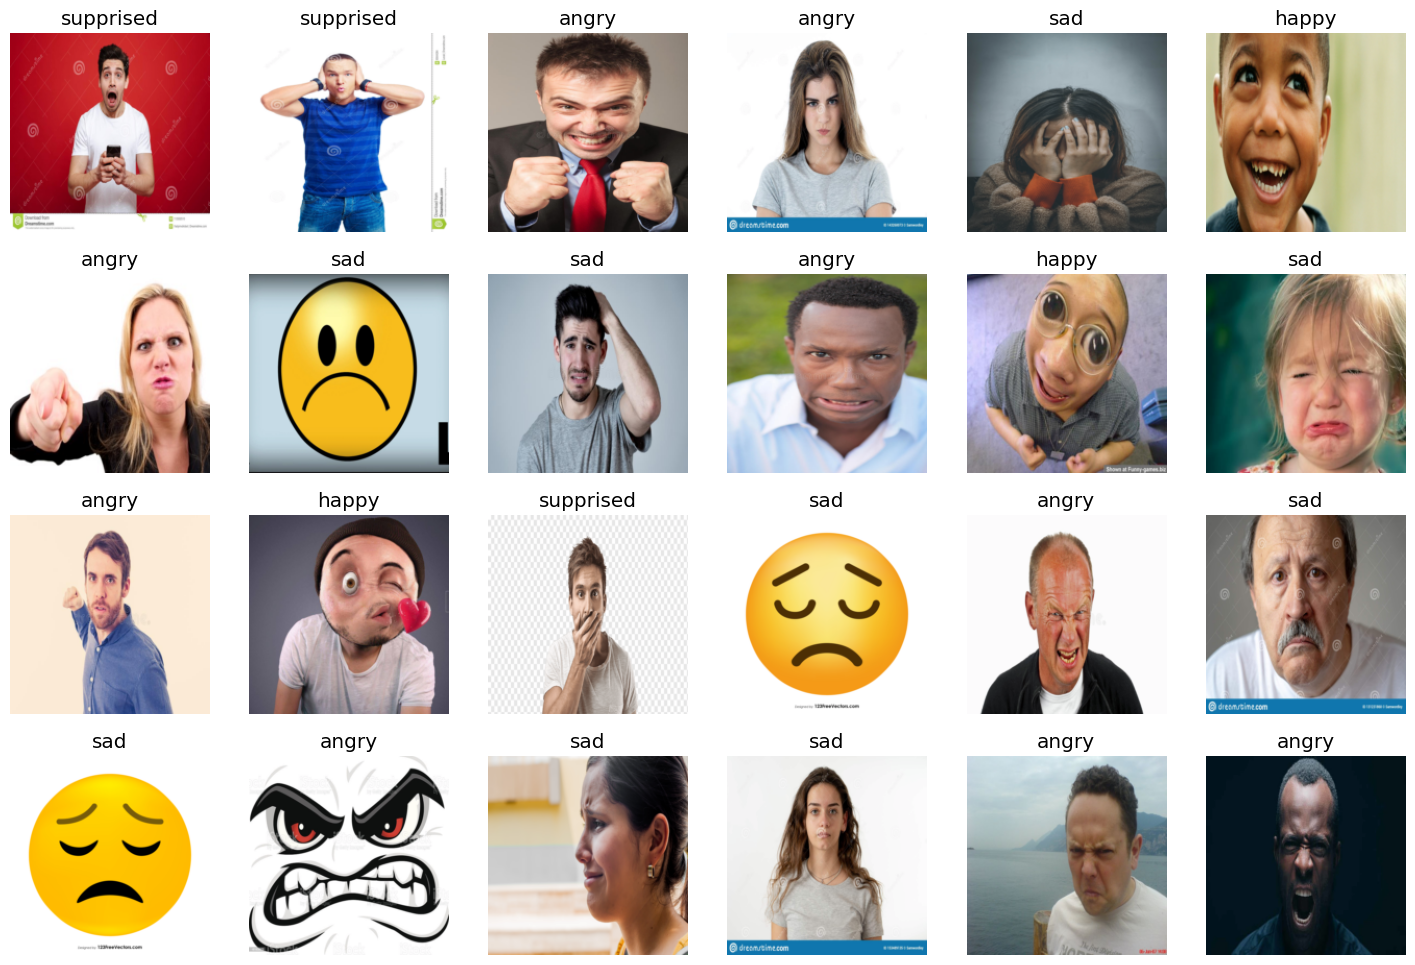

In [79]:
dls.show_batch(max_n=24)

In [64]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [72]:
emotion,_,probs = learn.predict(PILImage.create('sad.jpg'))
print(f"This is a: {emotion}.")
print(f"Probability it's a angry: {probs[0]:.4f}")
print(f"Probability it's a happy: {probs[1]:.4f}")
print(f"Probability it's a sad: {probs[2]:.4f}")
print(f"Probability it's a suprised: {probs[3]:.4f}")

This is a: sad.
Probability it's a angry: 0.0017
Probability it's a happy: 0.0005
Probability it's a sad: 0.9977
Probability it's a supprised: 0.0000


In [13]:
learn.export(model_path + '/emotion.pkl')

NameError: name 'learn' is not defined

In [14]:
#|export
learner = load_learner(model_path + '/emotion.pkl')

In [15]:
#|export
def classify_image(img):
    pred, idx, probs = learner.predict(img)
    return dict(zip(learner.dls.vocab, map(float, probs)))


In [16]:
classify_image(PILImage.create('sad.jpg'))

{'angry': 0.0016702483408153057,
 'happy': 0.0005412009195424616,
 'sad': 0.9977452158927917,
 'supprised': 4.334641562309116e-05}

In [17]:
#|export
import gradio as gr

image = gr.inputs.Image(shape=(192, 192))
label = gr.outputs.Label()
examples = [
    [data_path +'/test/happy.jpg'],
    [data_path +'/test/sad.jpg'],
    [data_path +'/test/angry.jpg'],
    [data_path +'/test/surprised.jpg']
]

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/Users/vojta/Library/Caches/pypoetry/virtualenvs/fast-ai-notebooks-oSgpAbbe-py3.9/lib/python3.9/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been dep

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [36]:
nbdev.export.nb_export('emotion-recognition-notebook.ipynb', './')